## MNIST Training and Prediction with SageMaker Chainer

[MNIST](http://yann.lecun.com/exdb/mnist/), the "Hello World" of machine learning, is a popular dataset for handwritten digit classification. It consists of 70,000 28x28 grayscale images labeled in 10 digit classes(0 to 9). This tutorial will show how to train on MNIST using SageMaker Chainer in [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk).

In [213]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

## Download MNIST datasets

We can use chainer built-in get_mnist() method to download, import and structure MNIST dataset. It may take several minutes to run this cell for the first time.

In [214]:
import chainer

try:
    os.makedirs('data/train')
    os.makedirs('data/test')
except FileExistsError:
    print('Directories already exist!')

train, test = chainer.datasets.get_mnist()

Directories already exist!


## Parse, save, and upload the data

Now we split each of training dataset and testing dataset to images and labels. Then it's convenient for us to save training data and testing data to npz files, a format that's popular in chainer world, to local filesystem. Then we can use `sagemaker.Session.upload_data` to upload the data to an S3 location used for training. The return value `inputs` identifies this S3 location.

In [215]:
import os

import numpy as np

train_images = np.array([data[0] for data in train])
train_labels = np.array([data[1] for data in train])
test_images = np.array([data[0] for data in test])
test_labels = np.array([data[1] for data in test])

np.savez('data/train/train.npz', images=train_images, labels=train_labels)
np.savez('data/test/test.npz', images=test_images, labels=test_labels)

train_input = sagemaker_session.upload_data(path=os.path.join('data', 'train'), key_prefix='notebook/chainer/mnist')
test_input = sagemaker_session.upload_data(path=os.path.join('data', 'test'), key_prefix='notebook/chainer/mnist')

## Prepare user script for training and prediction

We need to provide a user script that can run on the SageMaker platform. The script is essentially the same as one you would write for local training, except that a function `train` that returns a trained `chainer.Chain` model is required. By default, this model is saved to disk as an npz file named `model.npz`.
For prediciton, this script also requires a function `model_fn` that loads the `chainer.Chain` saved from training. When SageMaker calls your `train` and `model_fn` functions, it will pass in arguments that describe the training environment.

### TODO: Add link to README for user script writing here.

The below user script used in our tutorial is adapted from [chainer mnist example](https://github.com/chainer/chainer/blob/master/examples/mnist/train_mnist.py)

In [216]:
!cat 'chainer_mnist_single_machine.py'

#  Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#  
#      http://www.apache.org/licenses/LICENSE-2.0
#  
#  or in the "license" file accompanying this file. This file is distributed 
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either 
#  express or implied. See the License for the specific language governing 
#  permissions and limitations under the License.

from __future__ import print_function

import os

import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training, serializers
from chainer.training import extensions
from chainer.datasets import tuple_dataset


# Define the network to train MNIST
class MLP(chainer.Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
 

## Create SageMaker chainer estimator

To train MNIST, let's construct a `sagemaker.chainer.estimator.Chainer` estimator. A quick explanation for some configurable arguments here:

`entry_point`: The user script SageMaker runs for training and prediction.

`train_instance_count`: The number of SageMaker instances for training. Since we only do single machine training in this tutorial, it should be 1.

`train_instance_type`: The type of SageMaker instances for training. We choose `ml.c5.xlarge` for cpu training. If you want gpu training, you could choose other instance type accordingly. See [Amazon SageMaker ML Instance Types](https://aws.amazon.com/sagemaker/pricing/instance-types/)

`hyperparameters`: The hyper-parameters defined in the user script. In this tutorial, `epochs`, `batch_size` and `frequency` can be configured and passed.

In [217]:
from sagemaker.chainer.estimator import Chainer

chainer_estimator = Chainer(entry_point='chainer_mnist_single_machine.py', role=role,
                            sagemaker_session=sagemaker_session,
                            train_instance_count=1, train_instance_type='ml.c5.xlarge',
                            hyperparameters={'epochs': 16, 'batch_size': 128})

## Train on MNIST data in S3

After we've constructed our Chainer object, we can fit it using the MNIST data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our user script can simply read the data from disk.

In [218]:
chainer_estimator.fit({'train': train_input, 'test': test_input})

INFO:sagemaker:Creating training-job with name: sagemaker-chainer-2018-05-04-15-35-40-399


................................
2018-05-04 15:38:04,576 INFO - root - running container entrypoint
2018-05-04 15:38:04,577 INFO - root - starting train task
2018-05-04 15:38:04,579 INFO - container_support.app - started training: {'train_fn': <function train at 0x7f750b8f41e0>}
2018-05-04 15:38:04,715 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.170.2
2018-05-04 15:38:04,780 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-360423169059.s3.amazonaws.com
2018-05-04 15:38:04,839 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (2): sagemaker-us-west-2-360423169059.s3.amazonaws.com
2018-05-04 15:38:04,873 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-360423169059.s3.us-west-2.amazonaws.com
2018-05-04 15:38:04,933 INFO - botocore

#033[4A#033[J     total [##################................................] 36.00%
this epoch [#####################################.............] 76.00%
      2700 iter, 5 epoch / 16 epochs
    29.263 iters/sec. Estimated time to finish: 0:02:44.027371.
#033[4A#033[J     total [##################................................] 37.33%
this epoch [################################################..] 97.33%
      2800 iter, 5 epoch / 16 epochs
    29.268 iters/sec. Estimated time to finish: 0:02:40.587677.
#033[4A#033[J6           0.0200362   0.0783661             0.993503       0.978441                  96.7539       
#033[J     total [###################...............................] 38.67%
this epoch [#########.........................................] 18.67%
      2900 iter, 6 epoch / 16 epochs
        29 iters/sec. Estimated time to finish: 0:02:38.621622.
#033[4A#033[J     total [####################..............................] 40.00%
this epoch [####################........

#033[4A#033[J     total [#####################################.............] 74.67%
this epoch [###############################################...] 94.67%
      5600 iter, 11 epoch / 16 epochs
    28.161 iters/sec. Estimated time to finish: 0:01:07.468898.
#033[4A#033[J12          0.0157669   0.0893426             0.994909       0.979826                  200.228       
#033[J     total [######################################............] 76.00%
this epoch [########..........................................] 16.00%
      5700 iter, 12 epoch / 16 epochs
    28.032 iters/sec. Estimated time to finish: 0:01:04.212103.
#033[4A#033[J     total [######################################............] 77.33%
this epoch [##################................................] 37.33%
      5800 iter, 12 epoch / 16 epochs
    28.022 iters/sec. Estimated time to finish: 0:01:00.666571.
#033[4A#033[J     total [#######################################...........] 78.67%
this epoch [#########################

## Deploy model to endpoint

After training, we deploy the model to an endpoint using the Chainer estimator object.

In [219]:
predictor = chainer_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-chainer-2018-05-04-15-35-40-399
INFO:sagemaker:Creating endpoint with name sagemaker-chainer-2018-05-04-15-35-40-399


-------------------------------------------------------------!

## Predict Hand-Written Digit

We can now use this predictor to classify hand-written digits. Drawing into the image box loads the pixel data into a variable named 'data' in this notebook, which we can then pass to the Chainer predictor.

In [220]:
from IPython.display import HTML
HTML(open("input.html").read())

Now let's see if your writing can be recognized!

In [222]:
image = np.array(data, dtype=np.float32)
prediction = predictor.predict(image)
predicted_label = prediction.argmax(axis=1)[0]
print('What you wrote is: {}'.format(predicted_label))

What you wrote is: 7


We can also get some random test images in MNIST.

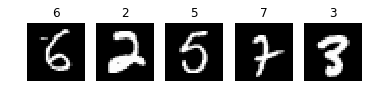

In [231]:
import random

import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(test_images.shape[0] - 1), num_samples)
images, labels = test_images[indices], test_labels[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

Now let's see if we can make correct predictions.

In [232]:
prediction = predictor.predict(images)
predicted_label = prediction.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))

The predicted labels are: [6 2 5 7 3]
